In [34]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

# We want our plots to appear in the notebook
%matplotlib inline 

## Models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from xgboost import XGBRegressor

## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score


import warnings
warnings.filterwarnings('ignore')

In [29]:
#Load Data
df = pd.read_csv("/kaggle/input/playground-series-s3e22/train.csv") 
df.shape 

(1235, 29)

In [30]:
df.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [5]:
#Check For Duplicates
duplicates = df.duplicated()
duplicates.sum()

0

In [6]:
# let's check unique values
columns=df.columns
for col in columns:
    print(col,':\n',df[col].unique())
    print(df[col].value_counts())
    print('\n',20*'**','\n')

id :
 [   0    1    2 ... 1232 1233 1234]
id
0       1
821     1
828     1
827     1
826     1
       ..
410     1
409     1
408     1
407     1
1234    1
Name: count, Length: 1235, dtype: int64

 **************************************** 

surgery :
 ['yes' 'no']
surgery
yes    887
no     348
Name: count, dtype: int64

 **************************************** 

age :
 ['adult' 'young']
age
adult    1160
young      75
Name: count, dtype: int64

 **************************************** 

hospital_number :
 [ 530001  533836  529812 5262541 5299629  529642  534787  529461  528742
  529640  528682  530028  528548  528134  528305  534885 5290482 5279822
  533692  535208  528523  529893  534145  530233  529399  530354  528503
  529796  527916  530360  528298  533871  529388  527563  534163  529827
  535196  535176  529045  527518  527463  529172  528996  533887  528904
  535407  533902  523190  534073  534135 5290409  529160  534917  534784
 5299253  534004  534115  529667 5297159  529427  

In [7]:
df.columns

Index(['id', 'surgery', 'age', 'hospital_number', 'rectal_temp', 'pulse',
       'respiratory_rate', 'temp_of_extremities', 'peripheral_pulse',
       'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis',
       'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux',
       'nasogastric_reflux_ph', 'rectal_exam_feces', 'abdomen',
       'packed_cell_volume', 'total_protein', 'abdomo_appearance',
       'abdomo_protein', 'surgical_lesion', 'lesion_1', 'lesion_2', 'lesion_3',
       'cp_data', 'outcome'],
      dtype='object')

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'hospital_number'}>,
        <Axes: title={'center': 'rectal_temp'}>],
       [<Axes: title={'center': 'pulse'}>,
        <Axes: title={'center': 'respiratory_rate'}>,
        <Axes: title={'center': 'nasogastric_reflux_ph'}>],
       [<Axes: title={'center': 'packed_cell_volume'}>,
        <Axes: title={'center': 'total_protein'}>,
        <Axes: title={'center': 'abdomo_protein'}>],
       [<Axes: title={'center': 'lesion_1'}>,
        <Axes: title={'center': 'lesion_2'}>,
        <Axes: title={'center': 'lesion_3'}>]], dtype=object)

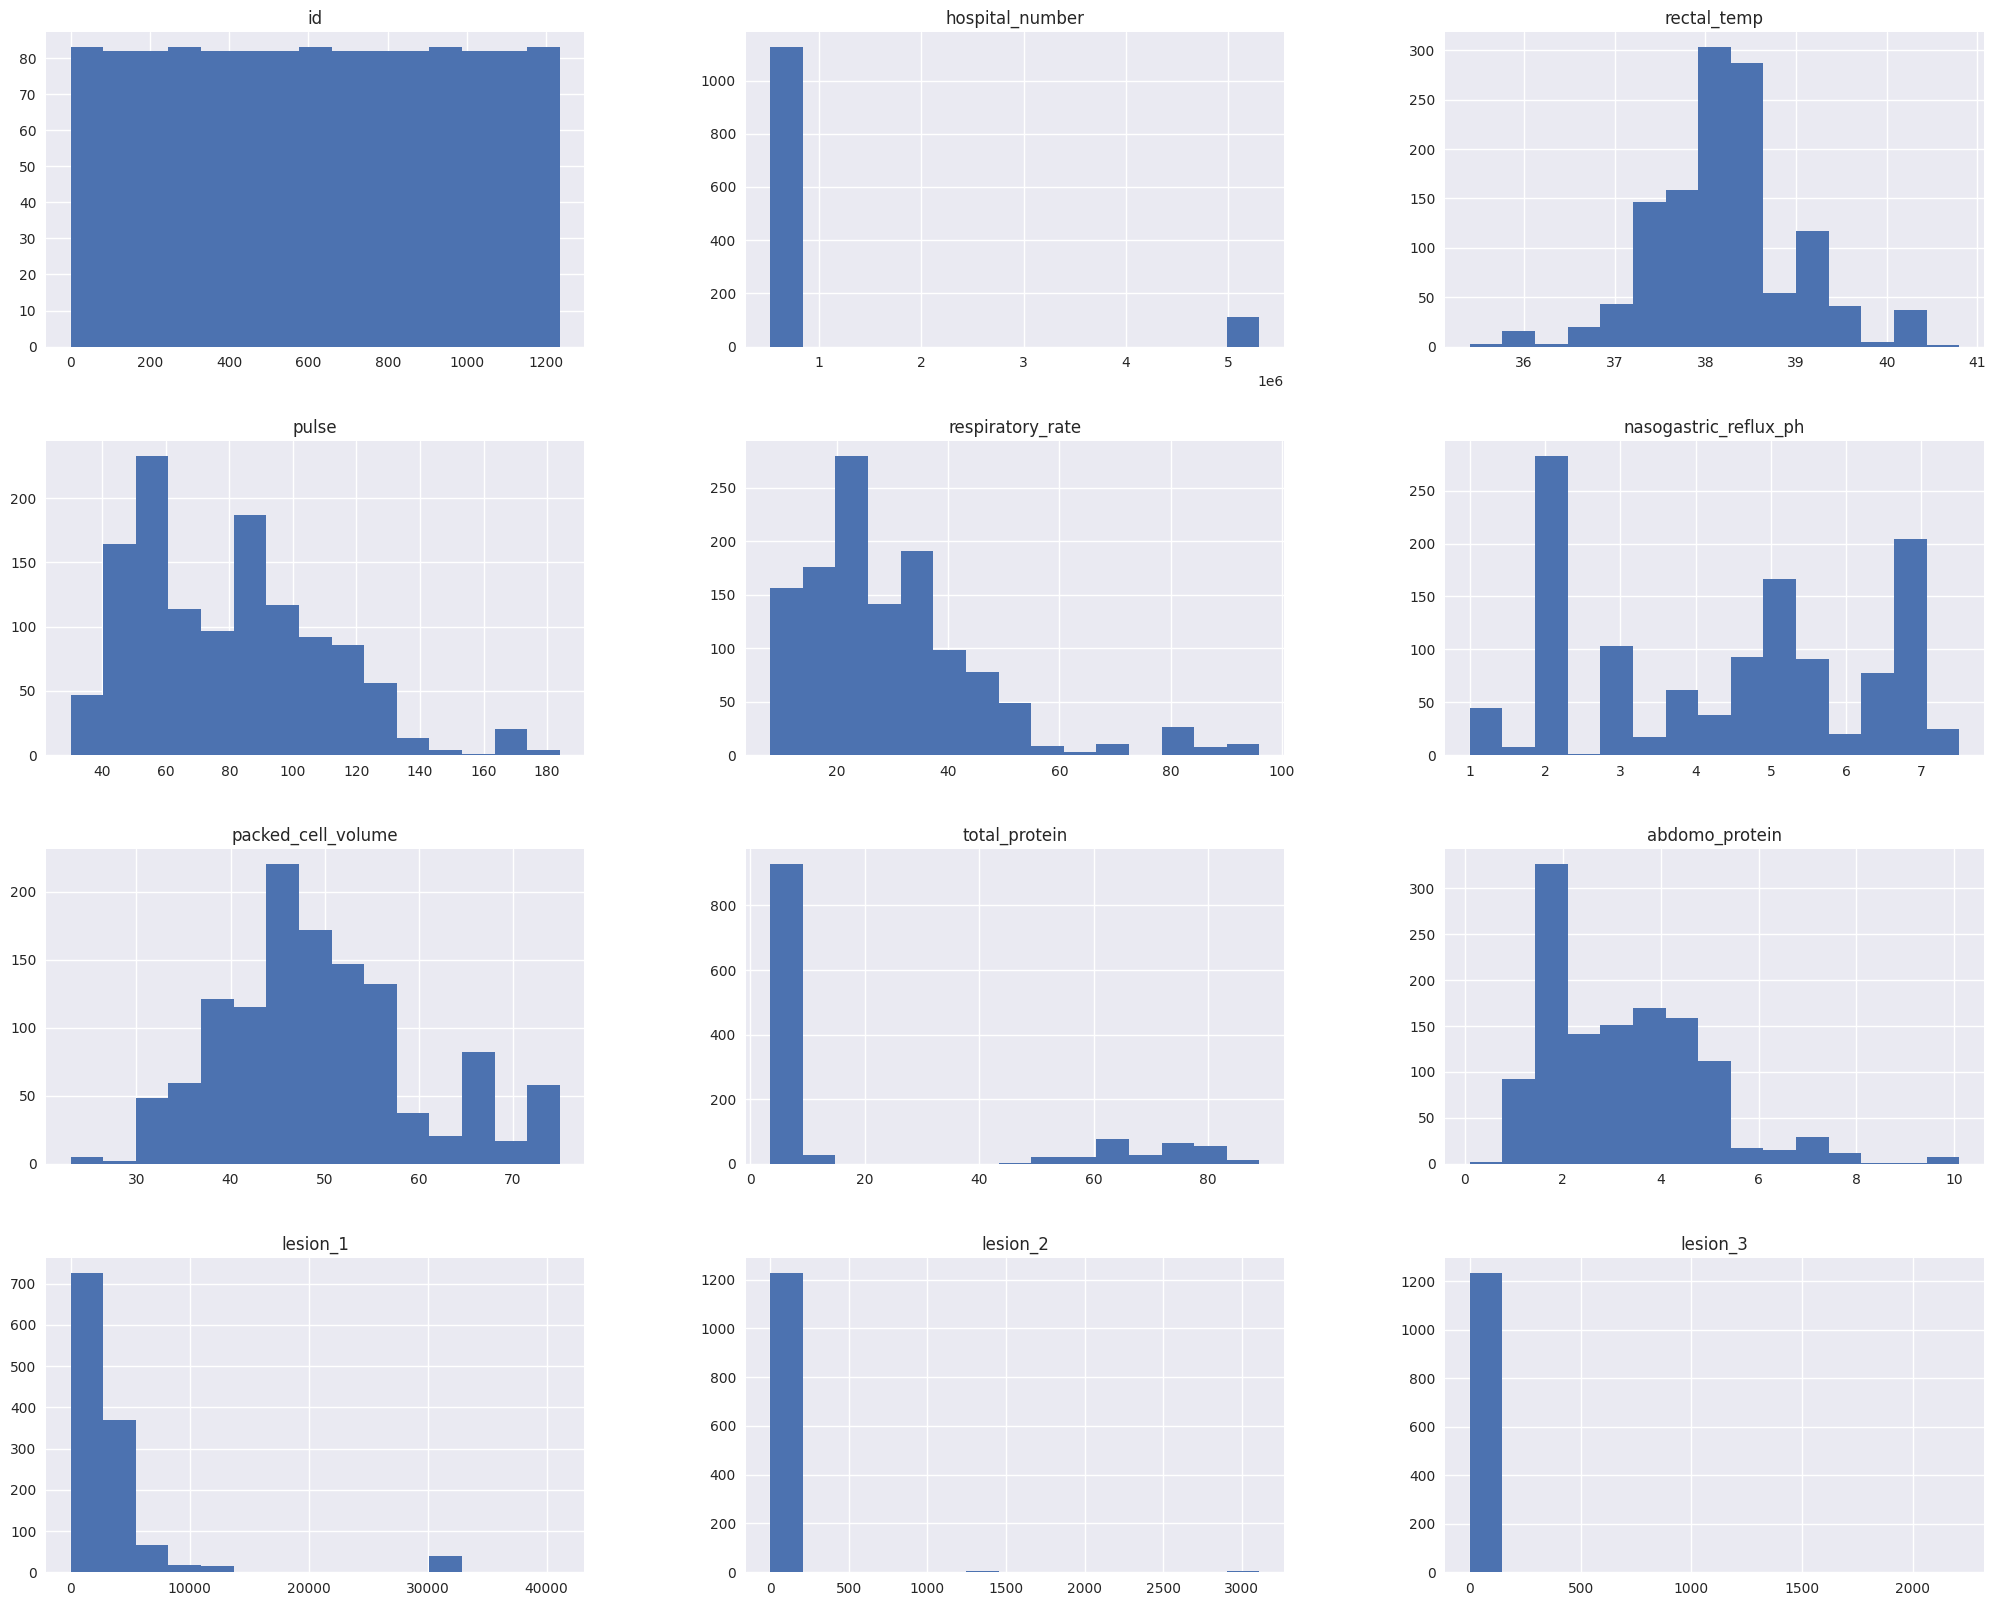

In [8]:
plt.style.use("seaborn")
df.hist(figsize=(25,20), bins=15)

In [9]:
df.describe()

,id,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3
count,1235.0000,1.235000e+03,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000
mean,617.0000,9.545004e+05,38.202186,79.574089,30.054251,4.382591,49.602429,21.388016,3.290931,3832.496356,14.612146,3.577328
std,356.6581,1.356403e+06,0.788668,29.108638,16.452066,1.937357,10.535800,26.676453,1.589195,5436.733774,193.705735,88.858953
min,0.0000,5.213990e+05,35.400000,30.000000,8.000000,1.000000,23.000000,3.500000,0.100000,0.000000,0.000000,0.000000
25%,308.5000,5.288000e+05,37.800000,53.000000,18.000000,2.000000,43.000000,6.600000,2.000000,2205.000000,0.000000,0.000000
50%,617.0000,5.297770e+05,38.200000,76.000000,28.000000,4.500000,48.000000,7.500000,3.000000,2209.000000,0.000000,0.000000
75%,925.5000,5.341450e+05,38.600000,100.000000,36.000000,6.000000,57.000000,9.100000,4.300000,3205.000000,0.000000,0.000000
max,1234.0000,5.305129e+06,40.800000,184.000000,96.000000,7.500000,75.000000,89.000000,10.100000,41110.000000,3112.000000,2209.000000


In [10]:
# Are there any missing values?
df.isna().sum()

id                         0
surgery                    0
age                        0
hospital_number            0
rectal_temp                0
pulse                      0
respiratory_rate           0
temp_of_extremities       39
peripheral_pulse          60
mucous_membrane           21
capillary_refill_time      6
pain                      44
peristalsis               20
abdominal_distention      23
nasogastric_tube          80
nasogastric_reflux        21
nasogastric_reflux_ph      0
rectal_exam_feces        190
abdomen                  213
packed_cell_volume         0
total_protein              0
abdomo_appearance         48
abdomo_protein             0
surgical_lesion            0
lesion_1                   0
lesion_2                   0
lesion_3                   0
cp_data                    0
outcome                    0
dtype: int64

In [13]:
# Fill missing values with the mean
df = df.fillna(df.mode())

In [16]:
# Fill missing values with the mean
df = df.fillna(df['temp_of_extremities'].mode().iloc[0])
df = df.fillna(df['peripheral_pulse'].mode().iloc[0])
df = df.fillna(df['mucous_membrane'].mode().iloc[0])
df = df.fillna(df['capillary_refill_time'].mode().iloc[0])
df = df.fillna(df['pain'].mode().iloc[0])
df = df.fillna(df['peristalsis'].mode().iloc[0])
df = df.fillna(df['abdominal_distention'].mode().iloc[0])
df = df.fillna(df['nasogastric_tube'].mode().iloc[0])
df = df.fillna(df['nasogastric_reflux'].mode().iloc[0])
df = df.fillna(df['rectal_exam_feces'].mode().iloc[0])
df = df.fillna(df['abdomen'].mode().iloc[0])
df = df.fillna(df['abdomo_appearance'].mode().iloc[0])

In [17]:
# Are there any missing values?
df.isna().sum()

id                       0
surgery                  0
age                      0
hospital_number          0
rectal_temp              0
pulse                    0
respiratory_rate         0
temp_of_extremities      0
peripheral_pulse         0
mucous_membrane          0
capillary_refill_time    0
pain                     0
peristalsis              0
abdominal_distention     0
nasogastric_tube         0
nasogastric_reflux       0
nasogastric_reflux_ph    0
rectal_exam_feces        0
abdomen                  0
packed_cell_volume       0
total_protein            0
abdomo_appearance        0
abdomo_protein           0
surgical_lesion          0
lesion_1                 0
lesion_2                 0
lesion_3                 0
cp_data                  0
outcome                  0
dtype: int64

In [18]:
df.drop(['id', 'hospital_number'],axis = 1,inplace = True)

In [19]:
df.head()

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,yes,adult,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,yes,adult,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,yes,adult,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,extreme_pain,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,yes,adult,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,no,adult,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [20]:
df['outcome'].unique()

array(['died', 'euthanized', 'lived'], dtype=object)

In [21]:
df['outcome'].value_counts()

outcome
lived         574
died          410
euthanized    251
Name: count, dtype: int64

In [22]:
from sklearn.preprocessing import LabelEncoder

Lb = LabelEncoder()

df['surgical_lesion']  = Lb.fit_transform(df['surgical_lesion'])
df['surgery']  = Lb.fit_transform(df['surgery'])
df['age']  = Lb.fit_transform(df['age'])
df['temp_of_extremities']  = Lb.fit_transform(df['temp_of_extremities'])
df['peripheral_pulse']  = Lb.fit_transform(df['peripheral_pulse'])
df['mucous_membrane']  = Lb.fit_transform(df['mucous_membrane'])
df['capillary_refill_time']  = Lb.fit_transform(df['capillary_refill_time'])
df['pain']  = Lb.fit_transform(df['pain'])
df['peristalsis']  = Lb.fit_transform(df['peristalsis'])
df['abdominal_distention']  = Lb.fit_transform(df['abdominal_distention'])
df['nasogastric_tube']  = Lb.fit_transform(df['nasogastric_tube'])
df['nasogastric_reflux']  = Lb.fit_transform(df['nasogastric_reflux'])
df['rectal_exam_feces']  = Lb.fit_transform(df['rectal_exam_feces'])
df['abdomen']  = Lb.fit_transform(df['abdomen'])
df['cp_data']  = Lb.fit_transform(df['cp_data'])
df['outcome']  = Lb.fit_transform(df['outcome'])
df['abdomo_appearance']  = Lb.fit_transform(df['abdomo_appearance'])

In [23]:
# Split data into X and y
X = df.drop("outcome", axis=1)

y = df["outcome"]

In [24]:
X

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,...,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,1,0,38.1,132.0,24.0,1,4,3,3,2,...,2,57.0,8.5,3,3.4,1,2209,0,0,0
1,1,0,37.5,88.0,12.0,1,3,5,3,4,...,2,33.0,64.0,3,2.0,1,2208,0,0,0
2,1,0,38.3,120.0,28.0,1,4,6,2,3,...,1,37.0,6.4,3,3.4,1,5124,0,0,0
3,1,0,37.1,72.0,30.0,0,4,6,3,4,...,2,53.0,7.0,1,3.9,1,2208,0,0,1
4,0,0,38.0,52.0,48.0,2,3,4,2,0,...,4,47.0,7.3,1,2.6,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,1,0,38.5,129.0,48.0,1,4,6,3,2,...,1,57.0,66.0,3,2.0,1,2206,0,0,0
1231,1,0,37.5,60.0,50.0,1,4,5,2,4,...,2,35.0,6.4,3,3.6,1,2209,0,0,1
1232,1,1,37.5,84.0,40.0,2,4,4,2,4,...,3,40.0,5.9,1,7.0,1,400,0,0,1
1233,1,0,38.1,70.0,16.0,2,4,1,2,4,...,2,58.0,74.0,1,2.0,1,2209,0,0,0


In [25]:
y

0       0
1       1
2       2
3       2
4       2
       ..
1230    2
1231    0
1232    2
1233    2
1234    2
Name: outcome, Length: 1235, dtype: int64

In [26]:
# Split data into train and test sets
np.random.seed(42)

# Split into train & test set
X_train, X_val, y_train, y_val = train_test_split(X,
                                                    y,
                                                    test_size=0.2)

In [38]:
# Put models in a dictionary
models = {"Catboost": CatBoostClassifier(),
          "Random Forest": RandomForestClassifier(),
         
          
}

# Create a function to fit and score models
def fit_and_score(models, X_train, X_val, y_train, y_val):
    """
    Fits and evaluates given machine learning models.
    models : a dict of differetn Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_val, y_val)
    return model_scores

In [39]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_val=X_val,
                             y_train=y_train,
                             y_val=y_val)

model_scores

Learning rate set to 0.079078
0:	learn: 1.0625487	total: 3.18ms	remaining: 3.17s
1:	learn: 1.0280513	total: 5.24ms	remaining: 2.61s
2:	learn: 0.9991193	total: 7.24ms	remaining: 2.4s
3:	learn: 0.9689377	total: 9.22ms	remaining: 2.29s
4:	learn: 0.9476719	total: 11.1ms	remaining: 2.21s
5:	learn: 0.9262242	total: 13ms	remaining: 2.15s
6:	learn: 0.9109895	total: 14.9ms	remaining: 2.12s
7:	learn: 0.8933693	total: 16.7ms	remaining: 2.07s
8:	learn: 0.8779918	total: 18.6ms	remaining: 2.04s
9:	learn: 0.8597549	total: 20.4ms	remaining: 2.02s
10:	learn: 0.8464693	total: 22.2ms	remaining: 2s
11:	learn: 0.8327194	total: 24ms	remaining: 1.97s
12:	learn: 0.8201721	total: 25.8ms	remaining: 1.96s
13:	learn: 0.8109798	total: 27.8ms	remaining: 1.96s
14:	learn: 0.7988127	total: 29.7ms	remaining: 1.95s
15:	learn: 0.7885956	total: 31.4ms	remaining: 1.93s
16:	learn: 0.7792301	total: 33.3ms	remaining: 1.92s
17:	learn: 0.7692752	total: 34.9ms	remaining: 1.91s
18:	learn: 0.7579069	total: 36.7ms	remaining: 1.9s
1

{'Catboost': 0.7004048582995951, 'Random Forest': 0.7206477732793523}

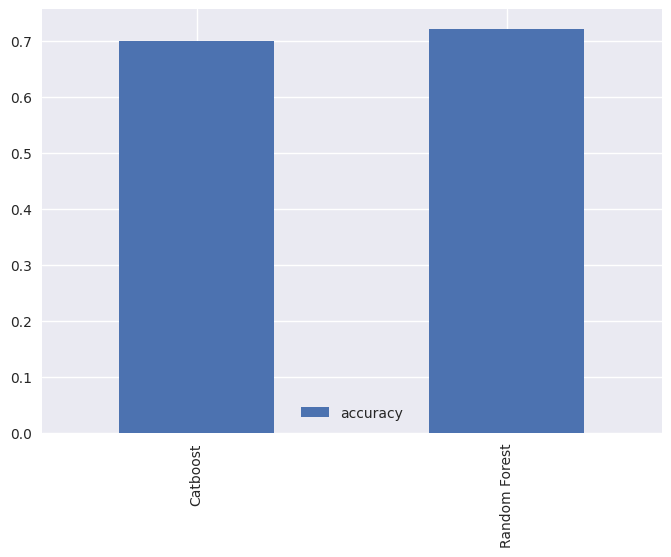

In [40]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar();